# DATA601

Joshua Black

## Exploring 'nb1' subset with text analytics

In [4]:
#Imports
from __future__ import print_function

import sys
import os
import glob
import re
import logging
from random import sample

import pandas as pd
import numpy as np
import scipy as sp
import networkx as nx

from gensim import corpora
from gensim.models import LdaMulticore, TfidfModel
from gensim.matutils import corpus2csc

from nltk.text import Text
from nltk.tokenize import RegexpTokenizer
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures
from nltk.corpus import stopwords, words

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from jupyter_dash import JupyterDash
import dash_cytoscape as cyto
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output, State

import NL_helpers
import NL_topicmodels # Will need to generate BOW using function in topic models.

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',
                    level=logging.INFO)

TOKENIZER = RegexpTokenizer(r"[A-Za-z']+")
STOPWORDS = set(stopwords.words())
WORDS = set(words.words())

In [ ]:
# Run cell to reload NL_helpers and NL_topicmodels if they have been changed.
from importlib import reload
reload(NL_helpers)
reload(NL_topicmodels)

### Loading Dataset

I have already generated a dataset containing all articles with the regex search term 'philoso*' run on the NL library. I load it as follows:

**Note, error:** the step at which I apply the search is before the text has been converted to lower case. The results of the re search are case sensitive. I had intended to include, e.g. 'Philosophy' as well. I don't expect that this will cause too many problems. 

In [5]:
philoso_df = pd.read_pickle('pickles/nb1_philoso_df.tar.gz')

In [6]:
philoso_df

,Title,Text
LT_18940102_ARTICLE9,HOW THEY GET ENGAGED IN GREENLAND.,[The missionaries in Greenland seem to have a ...
LT_18940102_ARTICLE12,SHEARING WET SHEEP.,"[TO THE EDITOR. Sir, —It being a matter of gre..."
LT_18940102_ARTICLE13,WORK AND WAGES.,"[TO THE EDITOR. Sir, —It appears that no cry o..."
LT_18940102_ARTICLE15,ROMANTIC WOMEN.,[Most women are inclined to be romantic. This ...
LT_18940102_ARTICLE41,IN MEMORIAM.,"[BISHOP HARPER. Ob., I)K. SS, 1533. “Go forth ..."
...,...,...
ODT_18790121_ARTICLE9,THE PRESBYTERIAN SYNOD OF OTAGO AND SOUTHLAND.,[FIFTH DAY. The Syrorl resumed its transaction...
ODT_18790121_ARTICLE15,THE SECOLD CHAIR OF MORAL PHILOSOPHY AND POLIT...,"[TO TJIE EDITOR, Sir,—You must not suppose iro..."
ODT_18790121_ARTICLE16,GODLESS EDUCATION. TO THE EDITOR,"[Sir,—l clxervo that the reft-reuce to tbo ""jj..."
ODT_18790121_ARTICLE17,THE BIBLE SCHOOLS. TO THE EDITOR.,"[Sia,—lt may not be out of place, in the prese..."


In [7]:
philoso_df['Tokenised'] = philoso_df['Text'].apply(
    lambda x: TOKENIZER.tokenize(NL_helpers.blocks2string(x).lower())
)

In [ ]:
# Duplicates ought to be removed from 'subset' corpus, but have already been removed from full 'philoso*' corpus.
# philoso_df = philoso_df[~philoso_df.astype(str).duplicated()]

In [8]:
# Counts by newspaper
philoso_df.index.map(lambda x: x[0:x.find('_')]).value_counts()

LT         38237
ODT        18353
ESD        17870
OW         15540
AS         15469
CHP        13972
HBH        13734
MEX        10722
NZTIM      10025
BH          8826
GRA         7720
DSC         7598
TC          7230
NOT         7035
LWM         7012
OAM         6506
NEM         6174
ME          5660
WH          5481
WC          4977
WT          4966
DTN         4717
MIC         4487
HNS         4062
WCT         3865
AG          3699
WSTAR       3123
WDT         3107
WI          2903
CROMARG     2799
FS          2376
MH          1976
HBT         1844
DUNST       1595
WEST        1505
WAIST       1483
IT          1433
HAST        1266
BA          1120
LCP         1047
CL           777
MS           736
MT           723
KUMAT        708
WOODEX       692
OO           629
NA           482
NZSCSG       387
OG           300
OPUNT        220
HBWT         176
HLC          172
NZGWS        101
WDA           78
NZCPNA        58
LTCBG         34
MTBM          21
ALG           10
NZABIG        

The above output shows that we have 29575 items containing 'philoso\*' in the whole dataset. This is between two and three times the size of the 'starter corpus', but is significantly smaller than the total corpus. **TODO: put full size here.**

I've also produced a count for each newspaper. OW - the Otago Witness tops the list. Surprising as this was a weekly paper and so should be expected to have less total issues than the others. However, it might have had more 'intellectual' content 

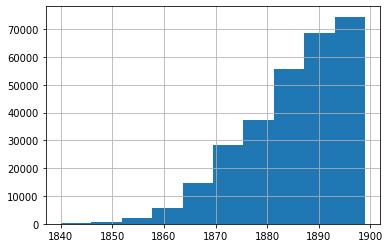

In [9]:
# Counts by year.
philoso_df.index.map(lambda x: int(x[x.find('_')+1:x.find('_')+5])).to_series().hist()

### Basic Exploration

#### Inspecting a subset of the corpus

We can look at a random subset of the corpus as follows:

In [ ]:
sample_indices = sample(list(philoso_df.index), 100)
interact(NL_helpers.html_text, index=sample_indices, dataframe=fixed(philoso_df), boldface=fixed('philoso*\\w*'))

#### Concordancing

We begin by quickly looking through concordances for key words. The initial 'flat list' of tokens is taken from a random sample of 1000 items in the corpus.

In [ ]:
flat_list = []
for tokens in philoso_df['Tokenised'].sample(n=1000, random_state=1):
    for token in tokens:
        flat_list.append(token)
sample_text = Text(flat_list)
del flat_list

This notebook keeps the full dataset in memory. I'll be using 'del' to remove references to large objects.

First up, 'philosophy':

In [ ]:
sample_text.concordance('philosophy', width=100, lines=150)

In [ ]:
sample_text.concordance('lecture', width=100, lines=150)

In [ ]:
del sample_text

#### Collocations

Collocations shows which words have a tendency to appear together *near one another* in documents (cf. co-occurrence). The ranking of word pairs depends on the statistic chosen.

**PMI:** pointwise mutual information is a measure from information theory. Suppose we have probability distributions for each word, *x* and *y*, we might wonder how much information about p(x) is carried by p(y). If the words *x* and *y* always occur together, then *pmi* will be very high. This makes PMI a good measure of word occurence (dreadful - come back once you've reminded yourself how this works).

**Likelihood ratio:**

The code below collects all immediate bigrams for a window of size 2 and of size 5. We then filter our bigrams which do not contain 'philosophy', those which appear less than three times, and those which contain stopwords.

We again build up a flat list, but this time with the whole corpus.

In [ ]:
flat_list = []
for tokens in philoso_df['Tokenised']:
    for token in tokens:
        flat_list.append(token)
all_text = Text(flat_list)
del flat_list

##### Window size = 2

In [ ]:
philoso_filter = lambda *w: 'philosophy' not in w
stopword_filter = lambda w: w in STOPWORDS

In [ ]:
bcf = BigramCollocationFinder.from_words(all_text)

In [ ]:
bcf.apply_ngram_filter(philoso_filter)
bcf.apply_word_filter(stopword_filter)
bcf.apply_freq_filter(10)

In [ ]:
bm = BigramAssocMeasures()

In [ ]:
pmi_ws2 = bcf.nbest(bm.pmi, 50)
pmi_ws2

With a window size of two, we get words either side of 'philosophy'.
Notes:
 - natural comes up again, along with 'experimental', 'positive', 'inductive'. 
 - 'pig philosophy' is, I think, a term of Carylye's - suggest some specific discussions.
 - most suggest intellectual discussion (except maybe 'proverbial'.

In [ ]:
lr_ws2 = bcf.nbest(bm.likelihood_ratio, 50)
lr_ws2

In [ ]:
pmi_not_lr = []
for collocation in pmi_ws2:
    if collocation not in lr_ws2:
        pmi_not_lr.append(collocation)
pmi_not_lr

In [ ]:
lr_not_pmi = []
for collocation in lr_ws2:
    if collocation not in pmi_ws2:
        lr_not_pmi.append(collocation)
lr_not_pmi

The differences here don't seem to make a big difference to the conclusions above. Not surprising as they are very closely related measures.

In [ ]:
del bcf
del all_text

##### Window size = 5

We can also expand the window to consider words either five spaces to the left or right of philosophy. (Window size includes stopwords)

In [ ]:
bcf_big = BigramCollocationFinder.from_words(all_text, window_size=5)

In [ ]:
bcf_big.apply_ngram_filter(philoso_filter)
bcf_big.apply_word_filter(stopword_filter)
bcf_big.apply_freq_filter(10)

In [ ]:
pmi_ws5 = bcf_big.nbest(bm.pmi, 50)
pmi_ws5

In [ ]:
lr_ws5 = bcf_big.nbest(bm.likelihood_ratio, 50)
lr_ws5

In [ ]:
pmi_not_lr_ws5 = []
for collocation in pmi_ws5:
    if collocation not in lr_ws5:
        pmi_not_lr_ws5.append(collocation)
pmi_not_lr_ws5

In [ ]:
lr_not_pmi_ws5 = []
for collocation in lr_ws5:
    if collocation not in pmi_ws5:
        lr_not_pmi_ws5.append(collocation)
lr_not_pmi_ws5

More difference in results here (more ngrams to choose between). But neither list gives a particularly different impression of the corpus as a whole.

In [ ]:
len(lr_not_pmi_ws5)

In [ ]:
del bcf_big, all_text

Differences in scoring more pronounced.

#### Co-occurence

To perform document-level cooccurence analysis we will shift from NLTK to gensim. We first build a dictionary.

This dictionary is much too large for our purposes (at ~70k words). We can filter stop words and all one and two letter words from the tokenized text to see what happens.

In [10]:
philoso_df['Tokenised'] = philoso_df['Tokenised'].map(lambda x: [word for word in x if len(word)>2 and not word in STOPWORDS and word in WORDS])

In [ ]:
# Me here
philoso_df['Entities'] = philoso_df['Entities'].map(lambda x: [i.lower() for i in x if len(i.lower()) > 2])

In [11]:
minimum_in_docs = 25 # 10
max_prop = 0.1
dictionary = corpora.Dictionary(philoso_df['Tokenised'])
dictionary.filter_extremes(no_below=minimum_in_docs, no_above=max_prop)
dictionary.compactify()

2021-01-19 09:37:35,917 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2021-01-19 09:37:38,023 : INFO : adding document #10000 to Dictionary(28283 unique tokens: ['accept', 'another', 'away', 'believe', 'bless']...)
2021-01-19 09:37:40,476 : INFO : adding document #20000 to Dictionary(34496 unique tokens: ['accept', 'another', 'away', 'believe', 'bless']...)
2021-01-19 09:37:42,809 : INFO : adding document #30000 to Dictionary(37969 unique tokens: ['accept', 'another', 'away', 'believe', 'bless']...)
2021-01-19 09:37:45,073 : INFO : adding document #40000 to Dictionary(39673 unique tokens: ['accept', 'another', 'away', 'believe', 'bless']...)
2021-01-19 09:37:47,406 : INFO : adding document #50000 to Dictionary(41834 unique tokens: ['accept', 'another', 'away', 'believe', 'bless']...)
2021-01-19 09:37:49,311 : INFO : adding document #60000 to Dictionary(43345 unique tokens: ['accept', 'another', 'away', 'believe', 'bless']...)
2021-01-19 09:37:51,465 : INFO : adding doc

In [12]:
dictionary.save(f'dictionaries/nb1_df_min{minimum_in_docs}_max{int(max_prop*100)}perc.dict')

2021-01-19 09:38:42,660 : INFO : saving Dictionary object under dictionaries/nb1_df_min25_max10perc.dict, separately None
2021-01-19 09:38:42,676 : INFO : saved dictionaries/nb1_df_min25_max10perc.dict


In [ ]:
philoso_df['BOW'] = philoso_df['Entities'].apply(lambda x: dictionary.doc2bow(x))    

In [13]:
philo_corpus = NL_topicmodels.NL_corpus(philoso_df, dictionary)

In [ ]:
tfidf_model = TfidfModel(philo_corpus, dictionary=philo_corpus.dictionary)

In [ ]:
philo_corpus.items

In [ ]:
philo_corpus.items['TF-IDF'] = tfidf_model[philo_corpus]

In [ ]:
philo_corpus.items

Changes over time? - I don't think this is helping me. Need some more non-philosophy as a background.

In [14]:
sparse = corpus2csc(philo_corpus.items['BOW'])

In [16]:
dtm = pd.DataFrame.sparse.from_spmatrix(sparse)

In [17]:
dtm.index = dictionary.values()

In [18]:
dtm.to_pickle('pickles/nb1_dtm_26kfiltered_10pc_dict.tar.gz')

In [ ]:
del dtm

In [ ]:
dtm = dtm.astype('Sparse[int8]')

In [ ]:
dtm.clip(lower=0,upper=1,inplace=True)

In [ ]:
binary_dtm

In [ ]:
tt_df = binary_dtm.dot(binary_dtm.transpose())

In [ ]:
tt = sparse.dot(sparse.transpose())

In [ ]:
sp.sparse.save_npz('pickles/tt_nb1_sparse.npz', tt)

In [ ]:
del sparse

In [ ]:
tt_df = pd.DataFrame.sparse.from_spmatrix(tt)

In [ ]:
tt_df.index = dictionary.values()

In [ ]:
tt_df.columns = dictionary.values()

In [ ]:
tt_df

In [ ]:
tt_df.to_pickle('pickles/nb1_tt_26kfiltered.pickle')

In [ ]:
tt_df

In [ ]:
# See https://tm4ss.github.io/docs/Tutorial_5_Co-occurrence.html
def dice_coocs(term, dtm, ttm, num_coocs):
    """Return num_coocs with dice statistics given search term
    document-term matrix and term-term matrix. Return as 
    pandas series with terms as indices and significances as values..
    ttm and dtm are pandas dataframes."""
    #num_documents = len(dtm.columns)
    all_term_occurrences = dtm.sum(axis=1)
    term_occurrences = all_term_occurrences[term]
    cooccurrences = ttm.loc[term]
    dicesig = 2 * cooccurrences / (term_occurrences + all_term_occurrences)
    dicesig = dicesig.sort_values(ascending=False)[0:num_coocs]
    return dicesig

In [ ]:
dicesig = 2 * cooccurrences / (term_occurrences + all_term_occurrences)

In [ ]:
type(dicesig)

In [ ]:
dicesig.sort_values(ascending=False)[0:15]

In [ ]:
dice_coocs('philosophy', binary_dtm, tt_df, 20)

In [ ]:
NL_helpers.log_dice_coocs('infinite', dtm, tt_df, 20)

In [ ]:
philo_cooc = dice_coocs('philosophy', binary_dtm, tt_df, 10)

In [ ]:
philo_network = NL_helpers.network_dataframe(
    term='philosophy', 
    stat='ml', 
    dtm=dtm,
    ttm=tt_df,
    num_coocs=10
)

In [ ]:
philo_network_df = pd.DataFrame(data=philo_network)

In [ ]:
network = {}
for item in philo_cooc.iteritems():
    from_list = network.get('source', [])
    from_list.append('philosophy')
    network['source'] = from_list
    to_list = network.get('target', [])
    to_list.append(item[0])
    network['target'] = to_list
    weight_list = network.get('weight', [])
    weight_list.append(item[1])
    network['weight'] = weight_list
    
    item_coocs = dice_coocs(item[0], binary_dtm, tt_df, 10)
    for sub_item in item_coocs.iteritems():
        if item[0] != sub_item[0]:
            from_list = network.get('source', [])
            from_list.append(item[0])
            network['source'] = from_list
            to_list = network.get('target', [])
            to_list.append(sub_item[0])
            network['target'] = to_list
            weight_list = network.get('weight', [])
            weight_list.append(sub_item[1])
            network['weight'] = weight_list
    

In [ ]:
network_df = pd.DataFrame(data=network)

In [ ]:
network_df

In [ ]:
G = nx.convert_matrix.from_pandas_edgelist(philo_network_df, edge_attr='weight')

In [ ]:
edges = G.edges()
weights = [np.exp(G[u][v]['weight']) * 0.01 for u,v in edges]

In [ ]:
d = nx.degree(G)
sizes = [(d[node]+1) * 100 for node in G.nodes()]

In [ ]:
layout = nx.drawing.layout.spring_layout(G, k=1/np.sqrt(len(G.nodes)))

In [ ]:
len(G.nodes)

In [ ]:
fig, ax = plt.subplots(figsize=(16, 16))
# Visualize graph components
nx.draw_networkx_edges(G, layout, alpha=0.5, width=weights, edge_color="m")
nx.draw_networkx_nodes(G, layout, node_size=sizes, node_color="#210070", alpha=0.9)
label_options = {"ec": "k", "fc": "white", "alpha": 0.7}
labels = nx.draw_networkx_labels(G, layout, font_size=11, bbox=label_options)

In [ ]:
philo_net = NL_helpers.network_dash(
    term='stout', 
    stat='log dice', 
    dtm=dtm,
    ttm=tt_df,
    num_coocs=25,
    sec_coocs=5
)

In [ ]:
philo_net

In [ ]:
app = JupyterDash(__name__)

philo_cytoscape = cyto.Cytoscape(
        id='philosophy-network',
        minZoom=1,
        layout={'name': 'cose'},
        style={'width': '100%', 'height': '800px'},
        elements=philo_net,
        stylesheet=[
            {
                'selector': 'edge',
                'style': {
                    'width': 'mapData(weight, 3, 6, 1, 3)',
                    'line-color': 'silver'
                }
            },
            {
                'selector': 'node',
                'style': {
                    'content': 'data(label)',
                    'width': 'mapData(size, 1, 10, 10, 20)',
                    'height': 'mapData(size, 1, 10, 10, 20)'
                }
            },
            {
                'selector': 'label',
                'style': {
                    'font-size': 6,
                    'text-valign': 'center',
                    'text-background-color': 'white',
                    'text-background-opacity': 0.6,
                    'text-background-padding': 1,
                    'text-border-color': 'black',
                    'text-border-opacity': 1,
                    'text-border-width': 0.5
                }
            }
        ]
    )

app.layout = html.Div([
    html.H2("Cooccurence Networks (BOW)"),
    html.P("Search Term:"),
    dcc.Input(
        id='search-term',
        type='text',
        value='stout'
    ),
    html.P("Statistic:"),
    dcc.Dropdown(
        id='stat-choice',
        options=[
            {'label': 'Mutual likelihood', 'value': 'ml'},
            {'label': 'Log Dice', 'value': 'log dice'}
        ],
        value='ml'
    ),
    html.Button('Submit', id='submit-val', n_clicks=0),
    philo_cytoscape
])

@app.callback(
    Output(component_id='philosophy-network', component_property='elements'),
    Input(component_id='submit-val', component_property='n_clicks'),
    State(component_id='stat-choice', component_property='value'),
    State(component_id='search-term', component_property='value'),
)
def update_network_stat(n_clicks, stat_value, search_value):
    network = NL_helpers.network_dash(
        term=search_value, 
        stat=stat_value, 
        dtm=dtm,
        ttm=tt_df,
        num_coocs=10,
        sec_coocs=5
    )
    return network 

if __name__ == '__main__':
    app.run_server(debug=True, mode='inline')